In [1]:
import os
from Bio import SeqIO
from Bio import AlignIO
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
import re

class OPGAlignmentAnalyzer:
    def __init__(self, fasta_file, gff_file, output_dir="opg_analysis2_clade_all"):
        self.fasta_file = fasta_file
        self.gff_file = gff_file
        self.output_dir = output_dir
        self.sequences = []
        self.opg_features = defaultdict(list)
        self.opg_alignments = {}
        self.opg_stats = {}
        os.makedirs(output_dir, exist_ok=True)
        
    def read_sequences(self):
        """FASTA 파일에서 시퀀스 읽기"""
        print("시퀀스 파일 읽는 중...")
        self.sequences = list(SeqIO.parse(self.fasta_file, "fasta"))
        print(f"읽은 시퀀스 수: {len(self.sequences)}")
        
    def parse_gff(self):
        """GFF 파일에서 OPG 정보 추출"""
        print("\nGFF 파일에서 OPG/CDS 정보 파싱 중...")
        with open(self.gff_file, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split('\t')
                if len(parts) < 9 or parts[2] != 'CDS':
                    continue
                    
                attributes = parts[8]
                # OPG ID 추출 (GFF 파일의 실제 형식에 맞게 수정 필요)
                opg_match = re.search(r'Name=([^;]+)', attributes)
                if opg_match:
                    opg_id = opg_match.group(1)
                    feature = {
                        'opg_id': opg_id,
                        'start': int(parts[3]),
                        'end': int(parts[4]),
                        'strand': parts[6],
                        'attributes': attributes
                    }
                    self.opg_features[opg_id].append(feature)
        
        print(f"파싱된 OPG 수: {len(self.opg_features)}")
        
    def align_opg_sequences(self):
        """각 OPG별로 시퀀스 추출 및 정렬"""
        print("\nOPG별 시퀀스 정렬 수행 중...")
        
        for opg_id, features in self.opg_features.items():
            print(f"\n처리 중: {opg_id}")
            for feature in features:
                # 각 시퀀스에서 OPG 영역 추출
                opg_sequences = []
                for seq in self.sequences:
                    region_seq = seq.seq[feature['start']-1:feature['end']]
                    if feature['strand'] == '-':
                        region_seq = region_seq.reverse_complement()
                    
                    opg_sequences.append(SeqIO.SeqRecord(
                        region_seq,
                        id=seq.id,
                        description=f"{opg_id} {feature['start']}-{feature['end']}"
                    ))
                
                # 임시 FASTA 파일 생성
                temp_fasta = os.path.join(self.output_dir, f"{opg_id}_sequences.fasta")
                SeqIO.write(opg_sequences, temp_fasta, "fasta")
                
                # MAFFT로 정렬
                output_file = os.path.join(self.output_dir, f"{opg_id}_aligned.fasta")
                try:
                    # MAFFT 경로 설정 (실제 경로로 수정 필요)
                    mafft_path = r"C:\Users\Rockefeller\Downloads\mafft-7.520-win64-signed\mafft-win\mafft.bat"
                    subprocess.run([mafft_path, "--auto", temp_fasta],
                                stdout=open(output_file, 'w'),
                                stderr=subprocess.PIPE,
                                text=True)
                    
                    # 정렬 결과 읽기
                    self.opg_alignments[opg_id] = AlignIO.read(output_file, "fasta")
                    
                    # 정렬 통계 계산
                    self.calculate_alignment_stats(opg_id)
                    
                except Exception as e:
                    print(f"정렬 오류 ({opg_id}): {str(e)}")
                
                # 임시 파일 삭제
                try:
                    os.remove(temp_fasta)
                except:
                    pass
                    
    def calculate_alignment_stats(self, opg_id):
        """각 OPG 정렬의 통계 계산"""
        alignment = self.opg_alignments[opg_id]
        length = alignment.get_alignment_length()
        n_seqs = len(alignment)
        
        # 위치별 보존도 계산
        conservation_scores = []
        variable_positions = []
        gaps = []
        
        for i in range(length):
            column = alignment[:, i]
            bases = [base for base in column if base != '-']
            
            if bases:
                most_common = max(set(bases), key=bases.count)
                conservation = bases.count(most_common) / len(bases)
                conservation_scores.append(conservation)
                
                if conservation < 1.0:
                    variable_positions.append(i)
                    
                if '-' in column:
                    gaps.append(i)
        
        self.opg_stats[opg_id] = {
            'length': length,
            'n_sequences': n_seqs,
            'mean_conservation': np.mean(conservation_scores),
            'variable_positions': len(variable_positions),
            'gap_positions': len(gaps),
            'conservation_scores': conservation_scores
        }
        
        
    def plot_opg_alignments(self):
        """OPG별 정렬 결과 시각화"""
        for opg_id, stats in self.opg_stats.items():
            plt.figure(figsize=(15, 6))
            
            # 보존도 프로필
            plt.subplot(2, 1, 1)
            plt.plot(stats['conservation_scores'], 'b-', alpha=0.6)
            plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.5)
            plt.title(f'{opg_id} 보존도 프로필')
            plt.xlabel('위치')
            plt.ylabel('보존도')
            plt.ylim(0, 1.1)
            
            # 통계 요약
            plt.subplot(2, 1, 2)
            summary_data = [
                stats['mean_conservation'] * 100,
                (stats['variable_positions'] / stats['length']) * 100,
                (stats['gap_positions'] / stats['length']) * 100
            ]
            
            plt.bar(['평균 보존도', '변이 비율', '갭 비율'], 
                   summary_data,
                   color=['green', 'red', 'blue'])
            plt.title(f'{opg_id} 통계 요약')
            plt.ylabel('비율 (%)')
            
            # 값 레이블 추가
            for i, v in enumerate(summary_data):
                plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, f'{opg_id}_analysis.png'))
            plt.close()
            
    def analyze(self):
        """전체 분석 수행"""
        self.read_sequences()
        self.parse_gff()
        self.align_opg_sequences()
        self.plot_opg_alignments()
        
        # 전체 OPG 비교 분석
        self.plot_opg_comparison()
        
    def plot_opg_comparison(self):
        """모든 OPG의 비교 분석 시각화"""
        data = []
        for opg_id, stats in self.opg_stats.items():
            data.append({
                'OPG': opg_id,
                'Length': stats['length'],
                'Conservation': stats['mean_conservation'] * 100,
                'Variables': stats['variable_positions'],
                'Gaps': stats['gap_positions']
            })
            
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(15, 10))
        
        # OPG별 보존도 비교
        plt.subplot(2, 1, 1)
        bars = plt.bar(df['OPG'], df['Conservation'], color='skyblue')
        plt.title('OPG별 평균 보존도')
        plt.xlabel('OPG')
        plt.ylabel('평균 보존도 (%)')
        plt.xticks(rotation=45, ha='right')
        
        # 값 레이블 추가
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom')
        
        # 변이와 갭의 관계
        plt.subplot(2, 1, 2)
        plt.scatter(df['Variables'], df['Gaps'], alpha=0.6)
        plt.xlabel('변이 위치 수')
        plt.ylabel('갭 위치 수')
        plt.title('변이와 갭의 관계')
        
        # OPG 레이블 추가
        for i, txt in enumerate(df['OPG']):
            plt.annotate(txt, (df['Variables'].iloc[i], df['Gaps'].iloc[i]))
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'opg_comparison_clade_all.png'))
        plt.close()
        
        # 결과를 CSV로 저장
        df.to_csv(os.path.join(self.output_dir, 'opg_analysis_summary_clade_all.csv'), index=False)
        print("\n분석 결과가 저장되었습니다:")
        print(f"- 그래프: {self.output_dir}")
        print(f"- 요약: opg_analysis_summary_clade_all.csv")

# 사용 예시
analyzer = OPGAlignmentAnalyzer(
    r"C:\Users\Rockefeller\OneDrive - 고려대학교\바탕 화면\Life\2023년도\대학원\KUKIST\Dr. Ryu\MPXV CRISPR-Cas\code\clade_accessions\mpxv_clade_all_sequences.fasta",
    "mpxv_reference.gff"
)
analyzer.analyze()

시퀀스 파일 읽는 중...
읽은 시퀀스 수: 388

GFF 파일에서 OPG/CDS 정보 파싱 중...
파싱된 OPG 수: 179

OPG별 시퀀스 정렬 수행 중...

처리 중: YP_010377002.1

처리 중: YP_010377003.1

처리 중: YP_010377004.1

처리 중: YP_010377005.1

처리 중: YP_010377006.1

처리 중: YP_010377007.1

처리 중: YP_010377008.1

처리 중: YP_010377009.1

처리 중: YP_010377010.1

처리 중: YP_010377011.1

처리 중: YP_010377012.1

처리 중: YP_010377013.1

처리 중: YP_010377014.1

처리 중: YP_010377015.1

처리 중: YP_010377017.1

처리 중: YP_010377018.1

처리 중: YP_010377019.1

처리 중: YP_010377020.1

처리 중: YP_010377021.1

처리 중: YP_010377022.1

처리 중: YP_010377023.1

처리 중: YP_010377025.1

처리 중: YP_010377026.1

처리 중: YP_010377027.1

처리 중: YP_010377028.1

처리 중: YP_010377029.1

처리 중: YP_010377030.1

처리 중: YP_010377031.1

처리 중: YP_010377032.1

처리 중: YP_010377033.1

처리 중: YP_010377034.1

처리 중: YP_010377035.1

처리 중: YP_010377036.1

처리 중: YP_010377037.1

처리 중: YP_010377038.1

처리 중: YP_010377039.1

처리 중: YP_010377040.1

처리 중: YP_010377041.1

처리 중: YP_010377042.1

처리 중: YP_010377043.1

처리 중: YP_010377044.1

처리 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840068.py:173: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840068.py:173: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840068.py:173: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840068.py:173: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840068.py:173: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41876\2283840


분석 결과가 저장되었습니다:
- 그래프: opg_analysis2_clade_all
- 요약: opg_analysis_summary_clade_all.csv


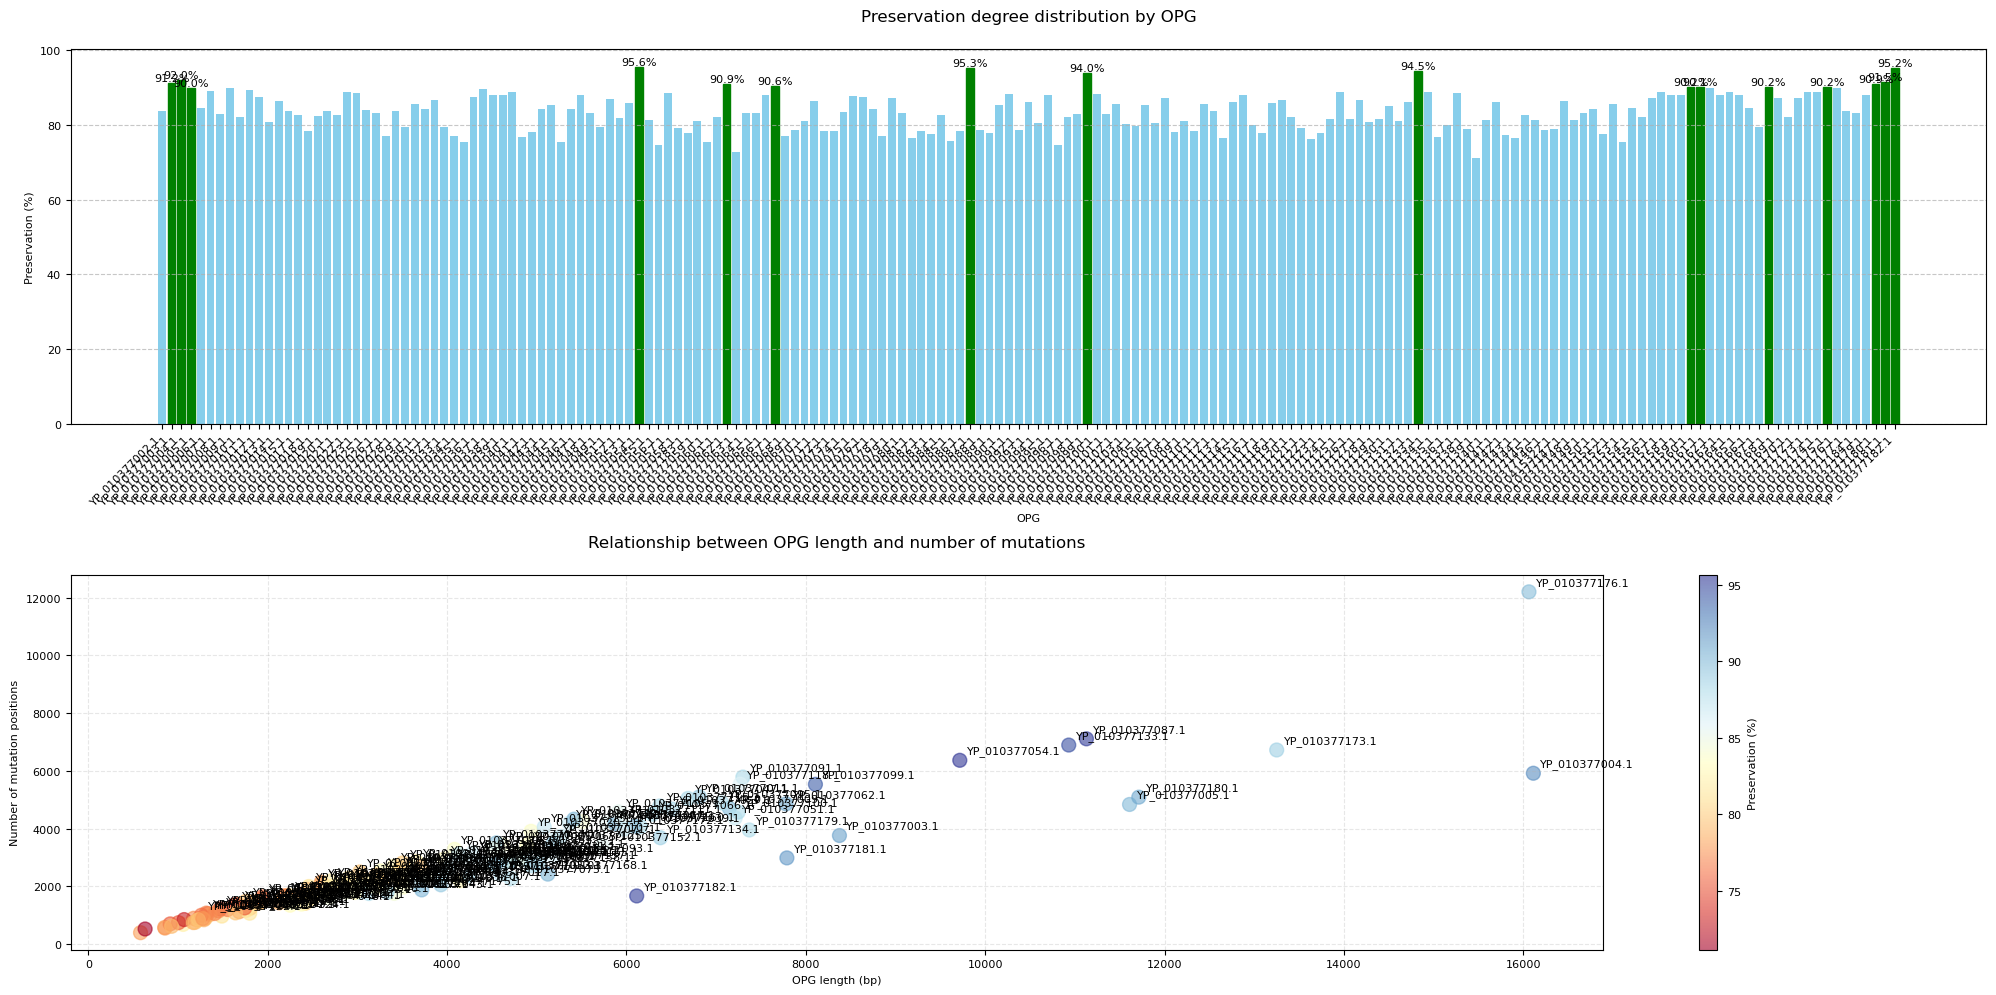


=== OPG 분석 요약 ===
총 OPG 수: 179
평균 보존도: 83.72%
완벽히 보존된 OPG (100%): 0
고도로 보존된 OPG (≥90%): 16
가장 긴 OPG: YP_010377004.1 (16113bp)
가장 많은 변이를 가진 OPG: YP_010377176.1 (12199 변이)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_opg_analysis(data_file):
    # 데이터 읽기
    df = pd.read_csv(data_file)
    
    # 폰트 크기 설정
    plt.rcParams.update({'font.size': 8})
    
    # 1. Conservation Rate 분포
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 1, 1)
    bars = plt.bar(range(len(df)), df['Conservation'], color='skyblue')
    plt.title('Preservation degree distribution by OPG', fontsize=12, pad=20)
    plt.ylabel('Preservation (%)')
    plt.xlabel('OPG')
    
    # x축 레이블 설정
    plt.xticks(range(len(df)), df['OPG'], rotation=45, ha='right')
    
    # 그리드 추가
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 90% 이상 보존된 OPG 강조
    for i, bar in enumerate(bars):
        if df['Conservation'].iloc[i] >= 90:
            bar.set_color('green')
            
    # 값 레이블 추가 (90% 이상만)
    for i, v in enumerate(df['Conservation']):
        if v >= 90:
            plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 2. Length vs Variables 관계
    plt.subplot(2, 1, 2)
    plt.scatter(df['Length'], df['Variables'], 
               alpha=0.6, 
               c=df['Conservation'],
               cmap='RdYlBu',
               s=100)
    
    plt.colorbar(label='Preservation (%)')
    plt.title('Relationship between OPG length and number of mutations', fontsize=12, pad=20)
    plt.xlabel('OPG length (bp)')
    plt.ylabel('Number of mutation positions')
    
    # 그리드 추가
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # 특이점 레이블 추가 (긴 길이 또는 많은 변이)
    for i, row in df.iterrows():
        if row['Length'] > 4000 or row['Variables'] > 1000:
            plt.annotate(row['OPG'], 
                        (row['Length'], row['Variables']),
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 3. 통계 요약
    print("\n=== OPG 분석 요약 ===")
    print(f"총 OPG 수: {len(df)}")
    print(f"평균 보존도: {df['Conservation'].mean():.2f}%")
    print(f"완벽히 보존된 OPG (100%): {len(df[df['Conservation'] == 100])}")
    print(f"고도로 보존된 OPG (≥90%): {len(df[df['Conservation'] >= 90])}")
    print(f"가장 긴 OPG: {df.loc[df['Length'].idxmax(), 'OPG']} ({df['Length'].max()}bp)")
    print(f"가장 많은 변이를 가진 OPG: {df.loc[df['Variables'].idxmax(), 'OPG']} ({df['Variables'].max()} 변이)")

# 사용 예시
plot_opg_analysis(r"C:\Users\Rockefeller\OneDrive - 고려대학교\바탕 화면\Life\2023년도\대학원\KUKIST\Dr. Ryu\MPXV CRISPR-Cas\code\opg_analysis2_clade_all\opg_analysis_summary_clade_all.csv")

In [3]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv(r"C:\Users\Rockefeller\OneDrive - 고려대학교\바탕 화면\Life\2023년도\대학원\KUKIST\Dr. Ryu\MPXV CRISPR-Cas\code\opg_analysis2_clade_all\opg_analysis_summary_clade_all.csv")

# Conservation_Rate가 100%인 OPG들 찾기
perfectly_conserved = df[df['Conservation'] >= 95].sort_values('Length', ascending=False)

# 결과 출력
print("\n=== 95% 이상 보존된 OPG (Conservation Rate ≥ 95%) ===")
print("\n주요 정보:")
print(perfectly_conserved[['OPG', 'Length', 'Conservation', 'Variables', 'Gaps']])


print("\n상세 통계:")
print(f"총 개수: {len(perfectly_conserved)} OPGs")
print(f"평균 길이: {perfectly_conserved['Length'].mean():.1f}bp")
print(f"최대 길이: {perfectly_conserved['Length'].max()}bp (OPG: {perfectly_conserved.iloc[0]['OPG']})")
print(f"최소 길이: {perfectly_conserved['Length'].min()}bp (OPG: {perfectly_conserved.iloc[-1]['OPG']})")

# 결과를 새로운 CSV 파일로 저장
perfectly_conserved.to_csv('≥95%_conserved_opgs_clade_all.csv', index=False)
print("\n결과가 '≥95%_conserved_opgs_clade_all.csv' 파일로 저장되었습니다.")


=== 95% 이상 보존된 OPG (Conservation Rate ≥ 95%) ===

주요 정보:
                OPG  Length  Conservation  Variables   Gaps
83   YP_010377087.1   11129     95.277312       7110  11129
49   YP_010377054.1    9717     95.640958       6366   9717
178  YP_010377182.1    6114     95.177757       1670   6114

상세 통계:
총 개수: 3 OPGs
평균 길이: 8986.7bp
최대 길이: 11129bp (OPG: YP_010377087.1)
최소 길이: 6114bp (OPG: YP_010377182.1)

결과가 '≥95%_conserved_opgs_clade_all.csv' 파일로 저장되었습니다.


In [21]:
from Bio import AlignIO
import numpy as np
from collections import defaultdict


def find_conserved_regions(alignment_file, conservation_threshold=0.95, min_region_length=20):
    try:
        alignment = AlignIO.read(f"opg_analysis2_clade_all/{alignment_file}_aligned.fasta", "fasta")
        length = alignment.get_alignment_length()
        conservation_scores = []
        conserved_positions = []
        
        for i in range(length):
            column = alignment[:, i]
            bases = [base for base in column if base != '-']
            
            if bases:
                if 'n' in bases or 'N' in bases:
                    conservation_scores.append(0)  # 여기서 추가
                    continue
                most_common = max(set(bases), key=bases.count)
                conservation = bases.count(most_common) / len(bases)
                conservation_scores.append(conservation)
                
                if conservation >= conservation_threshold:
                    conserved_positions.append(i)

        
        # 연속된 보존 영역 찾기
        conserved_regions = []
        current_region = []
        
        for i in range(len(conserved_positions)):
            if not current_region:
                current_region.append(conserved_positions[i])
            elif conserved_positions[i] == conserved_positions[i-1] + 1:
                current_region.append(conserved_positions[i])
            else:
                if len(current_region) >= min_region_length:
                    conserved_regions.append(current_region)
                current_region = [conserved_positions[i]]
        
        # 마지막 영역 처리
        if current_region and len(current_region) >= min_region_length:
            conserved_regions.append(current_region)
        
        # 결과 출력
        print(f"\n=== {alignment_file} Conserved Regions Analysis ===")
        print(f"Total sequence length: {length}bp")
        print(f"Number of conserved regions (≥{min_region_length}bp): {len(conserved_regions)}")
        
        # 각 보존 영역의 시퀀스 추출
        for i, region in enumerate(conserved_regions, 1):
            start = region[0]
            end = region[-1] + 1
            consensus_seq = ""
            
            # 해당 영역의 컨센서스 시퀀스 구하기
            for pos in range(start, end):
                column = alignment[:, pos]
                bases = [base for base in column if base != '-']
                if bases:
                    consensus_seq += max(set(bases), key=bases.count)
            
            print(f"\nConserved Region {i}:")
            print(f"Position: {start+1}-{end} (Length: {end-start}bp)")
            print(f"Consensus sequence:")
            print(consensus_seq)
            
            # 이 영역의 평균 보존도 계산
            region_conservation = np.mean([conservation_scores[pos] for pos in region])
            print(f"Average conservation in this region: {region_conservation*100:.2f}%")
        
        return conserved_regions, conservation_scores
        
    except Exception as e:
        print(f"Error analyzing {alignment_file}: {str(e)}")
        return None, None

# 분석할 OPG들
opgs = ['YP_010377087.1', 'YP_010377054.1', 'YP_010377182.1']

# 각 OPG에 대해 분석 수행
for opg in opgs:
    regions, scores = find_conserved_regions(opg)
    if regions:
        print(f"\nTotal number of conserved regions found in {opg}: {len(regions)}")
        
        # 가장 긴 보존 영역 찾기
        longest_region = max(regions, key=len)
        print(f"Longest conserved region: {len(longest_region)}bp (Position: {longest_region[0]+1}-{longest_region[-1]+1})")


=== YP_010377087.1 Conserved Regions Analysis ===
Total sequence length: 11129bp
Number of conserved regions (≥20bp): 37

Conserved Region 1:
Position: 1-149 (Length: 149bp)
Consensus sequence:
acgacgtgctaatctagcgtgtgaagacgataaattaatgatctatggattaccatggataacaactcaaacatctgcgttatcaataaatagtaaaccgatagtgtataaagattgtgcaaagcttttgcgatcaataaatggatcac
Average conservation in this region: 100.00%

Conserved Region 2:
Position: 151-773 (Length: 623bp)
Consensus sequence:
accagtatctcttaacgatgttcttcgcagatgatgattcattttttaagtattttgctagtcaagatgatgaatcttcattatctgatatattgcaaatcactcaatatctagactttctgttattattattgatccaatcaaaaaataaattagaagctgtgggtcattgttatgaatctctttcagaggaatacagacaattgacaaaattcacagactctcaagattttaaaaaactgtttaacaaggtccctattgttacagatggaagggtcaaacttaataaaggatatttgttcgactttgtgattagtttgatgcgattcaaaaaagaatcagctctagctaccaccgcaatagatcctgttagatacatagatcctcgtcgtgatatcgcattttctaacgtgatggatatattaaagtcgaataaagttgaacaataattaattctttattgttatcatgaacggcggacatattcagttgataatcggccccatgttttcaggtaaaagtacagaattaatta

In [22]:
from Bio import AlignIO
import numpy as np
from collections import defaultdict


def find_conserved_regions(alignment_file, conservation_threshold=0.1, min_region_length=20):
    try:
        alignment = AlignIO.read(f"opg_analysis2_clade_all/{alignment_file}_aligned.fasta", "fasta")
        length = alignment.get_alignment_length()
        conservation_scores = []
        conserved_positions = []
        
        for i in range(length):
            column = alignment[:, i]
            bases = [base for base in column if base != '-']
            
            if bases:
                if 'n' in bases or 'N' in bases:
                    conservation_scores.append(0)  # 여기서 추가
                    continue
                most_common = max(set(bases), key=bases.count)
                conservation = bases.count(most_common) / len(bases)
                conservation_scores.append(conservation)
                
                if conservation >= conservation_threshold:
                    conserved_positions.append(i)

        
        # 연속된 보존 영역 찾기
        conserved_regions = []
        current_region = []
        
        for i in range(len(conserved_positions)):
            if not current_region:
                current_region.append(conserved_positions[i])
            elif conserved_positions[i] == conserved_positions[i-1] + 1:
                current_region.append(conserved_positions[i])
            else:
                if len(current_region) >= min_region_length:
                    conserved_regions.append(current_region)
                current_region = [conserved_positions[i]]
        
        # 마지막 영역 처리
        if current_region and len(current_region) >= min_region_length:
            conserved_regions.append(current_region)
        
        # 결과 출력
        print(f"\n=== {alignment_file} Conserved Regions Analysis ===")
        print(f"Total sequence length: {length}bp")
        print(f"Number of conserved regions (≥{min_region_length}bp): {len(conserved_regions)}")
        
        # 각 보존 영역의 시퀀스 추출
        for i, region in enumerate(conserved_regions, 1):
            start = region[0]
            end = region[-1] + 1
            consensus_seq = ""
            
            # 해당 영역의 컨센서스 시퀀스 구하기
            for pos in range(start, end):
                column = alignment[:, pos]
                bases = [base for base in column if base != '-']
                if bases:
                    consensus_seq += max(set(bases), key=bases.count)
            
            print(f"\nConserved Region {i}:")
            print(f"Position: {start+1}-{end} (Length: {end-start}bp)")
            print(f"Consensus sequence:")
            print(consensus_seq)
            
            # 이 영역의 평균 보존도 계산
            region_conservation = np.mean([conservation_scores[pos] for pos in region])
            print(f"Average conservation in this region: {region_conservation*100:.2f}%")
        
        return conserved_regions, conservation_scores
        
    except Exception as e:
        print(f"Error analyzing {alignment_file}: {str(e)}")
        return None, None

# 분석할 OPG들
opgs = ['YP_010377087.1', 'YP_010377054.1', 'YP_010377182.1']

# 각 OPG에 대해 분석 수행
for opg in opgs:
    regions, scores = find_conserved_regions(opg)
    if regions:
        print(f"\nTotal number of conserved regions found in {opg}: {len(regions)}")
        
        # 가장 긴 보존 영역 찾기
        longest_region = max(regions, key=len)
        print(f"Longest conserved region: {len(longest_region)}bp (Position: {longest_region[0]+1}-{longest_region[-1]+1})")


=== YP_010377087.1 Conserved Regions Analysis ===
Total sequence length: 11129bp
Number of conserved regions (≥20bp): 22

Conserved Region 1:
Position: 1-1142 (Length: 1142bp)
Consensus sequence:
acgacgtgctaatctagcgtgtgaagacgataaattaatgatctatggattaccatggataacaactcaaacatctgcgttatcaataaatagtaaaccgatagtgtataaagattgtgcaaagcttttgcgatcaataaatggatcacaaccagtatctcttaacgatgttcttcgcagatgatgattcattttttaagtattttgctagtcaagatgatgaatcttcattatctgatatattgcaaatcactcaatatctagactttctgttattattattgatccaatcaaaaaataaattagaagctgtgggtcattgttatgaatctctttcagaggaatacagacaattgacaaaattcacagactctcaagattttaaaaaactgtttaacaaggtccctattgttacagatggaagggtcaaacttaataaaggatatttgttcgactttgtgattagtttgatgcgattcaaaaaagaatcagctctagctaccaccgcaatagatcctgttagatacatagatcctcgtcgtgatatcgcattttctaacgtgatggatatattaaagtcgaataaagttgaacaataattaattctttattgttatcatgaacggcggacatattcagttgataatcggccccatgttttcaggtaaaagtacagaattaattagacgagttagacgttatcaaatagctcaatataaatgtgtgactataaaatattctaacgataatagatacggaacgggactatggacgcatgataagaataattttgcagcattgga